In [1]:
!pip install --upgrade fastai fastcore timm kaggle pynvml nbdev -qq

     |████████████████████████████████| 549 kB 17.6 MB/s 
     |████████████████████████████████| 46 kB 900 kB/s 
     |████████████████████████████████| 64 kB 778 kB/s 
     |████████████████████████████████| 182 kB 2.7 MB/s 
     |████████████████████████████████| 78 kB 2.0 MB/s 
     |████████████████████████████████| 58 kB 1.7 MB/s 
     |████████████████████████████████| 1.6 MB 18.7 MB/s 


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# from pathlib import Path
# base_folder = Path("/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/")

In [1]:
pwd

'd:\\OneDrive - The University of Texas at Dallas\\6382\\Assignment 8'

In [2]:
from pathlib import Path
base_folder = Path("d:\\OneDrive - The University of Texas at Dallas\\6382\\Datasets")

In [19]:
data_folder = base_folder/'data'
model_folder = base_folder/'models/Inclass_DL_Kaggle_Comp'
archive_folder = base_folder/'archive'
kaggle_api = base_folder/'.kaggle'

In [ ]:
# data_folder = base_folder/'paddi-disease-classification'
# model_folder = base_folder/'models/paddi-disease-classification'
# archive_folder = base_folder/'archive'
# kaggle_api = base_folder/'.kaggle'

In [11]:
data_folder.mkdir(exist_ok = True)
model_folder.mkdir(exist_ok= True)
archive_folder.mkdir(exist_ok = True)
kaggle_api.mkdir(exist_ok = True)

In [4]:
archive_folder

WindowsPath('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/archive')

In [ ]:
!ls -la /content/drive/My\ Drive/Colab\ Notebooks/Deep\ Learning/Datasets/.kaggle

total 1
-rw------- 1 root root 73 Nov 19 22:23 kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/.kaggle'

In [5]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/.kaggle'

In [14]:
! chmod 700 '/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/.kaggle/kaggle.json'

In [8]:
import torch
from fastai.vision.all import *
# from kaggle import api
from fastcore.parallel import *
import timm
import pynvml

In [ ]:
# api.competition_download_cli('paddy-disease-classification', path='/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/archive/')

100%|██████████| 1.02G/1.02G [00:07<00:00, 147MB/s]

In [ ]:
#!unzip -q '/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/archive/paddy-disease-classification.zip' -d '/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/paddi-disease-classification'

In [9]:
Path.BASE_PATH = data_folder

In [20]:
train_path = data_folder/'train'
test_path = data_folder/'test'

In [22]:
train_files = get_image_files(train_path)
test_files = get_image_files(test_path)

In [23]:
test_files

(#3929) [Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/0.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/10.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/100.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1000.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1001.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1002.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1003.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1004.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1005.JPEG')...]

In [20]:
train_labels = [parent_label(o) for o in train_files]

In [ ]:
pd.Series(train_labels).value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
dtype: int64

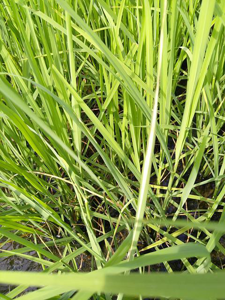

In [ ]:
img = PILImage.create(train_files[0])
img.to_thumb(h=300)

In [ ]:
img.size

(480, 640)

In [ ]:
def get_img_size(file):
    return PILImage.create(file).size

In [ ]:
train_size = parallel(get_img_size, train_files)

In [ ]:
train_size.unique()

(#2) [(480, 640),(640, 480)]

In [ ]:
df_kaggle_train = pd.read_csv(data_folder/'train.csv')

In [ ]:
df_kaggle_train.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
df_train_sizes = pd.Series(train_size)

In [ ]:
df_train_sizes.value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

In [24]:
dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms= Resize(size= (480, 480), method = 'squish'),
                   batch_tfms= aug_transforms(size = (128, 128), min_scale = 1)
                   )

In [25]:
dls = dblock.dataloaders(data_folder/'train/train', bs = 64)

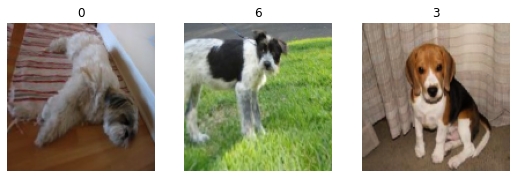

In [26]:
dls.train.show_batch(max_n = 3)

In [28]:
learn = vision_learner(dls, 'convnext_tiny', metrics= error_rate, path = model_folder).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to C:\Users\piyus/.cache\torch\hub\checkpoints\convnext_tiny_1k_224_ema.pth


SuggestedLRs(minimum=0.00831763744354248, steep=0.0006918309954926372, valley=0.0010000000474974513, slide=6.309573450380412e-07)

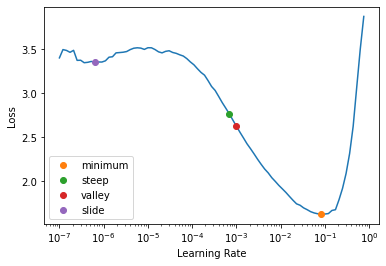

In [29]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [31]:
torch.cuda.empty_cache()
learn.fine_tune(3, 0.008)

epoch,train_loss,valid_loss,error_rate,time
0,0.396149,0.317413,0.079224,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.269769,0.278127,0.069806,00:47
1,0.209671,0.195796,0.058726,00:48
2,0.128613,0.183994,0.055956,00:51


In [32]:
test_dl = dls.test_dl(test_files)

In [33]:
preds, _ = learn.tta(dl = test_dl)

In [34]:
idxs = preds.argmax(dim = 1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name = 'idxs')

In [35]:
ss = pd.read_csv(data_folder/'sample_submission.csv')
ss['target'] = 0
ss.head(10)

,file_names,target
0,0.JPEG,0
1,1.JPEG,0
2,2.JPEG,0
3,3.JPEG,0
4,4.JPEG,0
5,5.JPEG,0
6,6.JPEG,0
7,7.JPEG,0
8,8.JPEG,0
9,9.JPEG,0


In [36]:
ss.sort_values(by = ['file_names'], inplace = True, ignore_index = True)
ss['target'] = results
ss.head(10)

,file_names,target
0,0.JPEG,7
1,1.JPEG,2
2,10.JPEG,0
3,100.JPEG,5
4,1000.JPEG,3
5,1001.JPEG,5
6,1002.JPEG,3
7,1003.JPEG,4
8,1004.JPEG,8
9,1005.JPEG,1


In [37]:
ss.to_csv(archive_folder/'subm.csv', index = False)

In [ ]:
api.competition_submit('/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/archive/inclass.csv', 'inclass_dl_nov28', 'inclassdlfall22')

In [ ]:
dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms= Resize(size= (640, 480), method = 'squish'),
                   batch_tfms= aug_transforms(size = (320, 240), min_scale = 1)
                   )

In [ ]:
doc(RandomSplitter)

In [ ]:
doc(DataBlock)

In [ ]:
doc(Resize)

In [ ]:
doc(aug_transforms)

In [ ]:
dblock.summary(data_folder/'train_images')

Setting-up type transforms pipelines
Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/paddi-disease-classification/train_images/downy_mildew/103369.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=480x640
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/paddi-disease-classification/train_images/downy_mildew/103369.jpg
    applying parent_label gives
      downy_mildew
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=480x640, TensorCategory(6))


Found 10407 items
2 datasets of sizes 8326,

In [ ]:
dls = dblock.dataloaders(data_folder/'train_images')

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

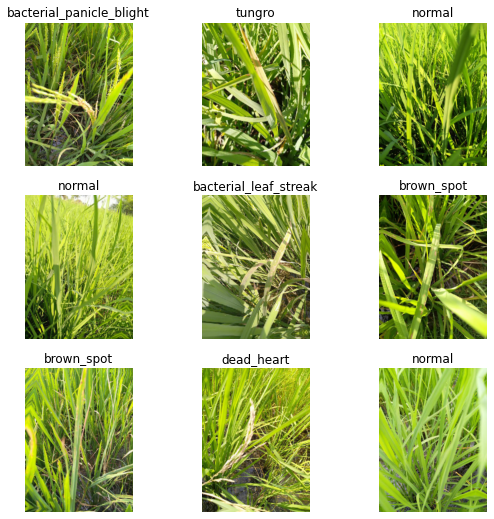

In [ ]:
dls.train.show_batch()

In [ ]:
def get_dataloaders(itfms, btfms):
    dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms= itfms,
                   batch_tfms= btfms
                   )
    set_seed(42)
    dls = dblock.dataloaders(train_files[0,1000,5000], bs = 3)
    dls.train.show_batch(max_n = 3)

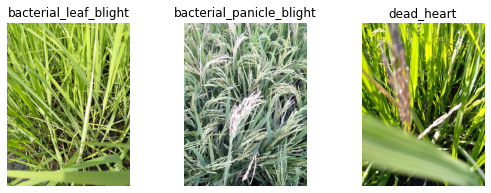

In [ ]:
itfms = Resize((640, 480))
btfms = None
get_dataloaders(itfms, btfms)

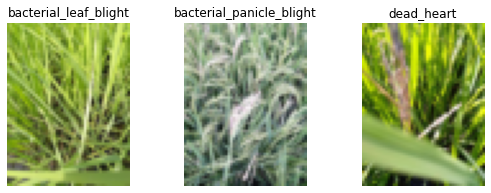

In [ ]:
itfms = Resize((64, 48))
btfms = None
get_dataloaders(itfms, btfms)

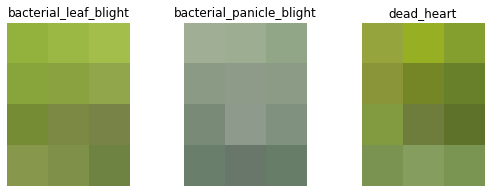

In [ ]:
itfms = Resize((4, 3))
btfms = None
get_dataloaders(itfms, btfms)

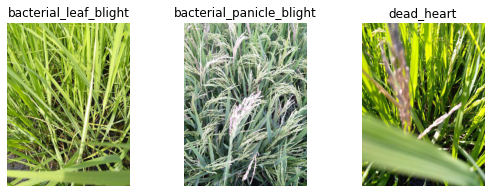

In [ ]:
itfms = Resize((800,600))
btfms = None
get_dataloaders(itfms, btfms)

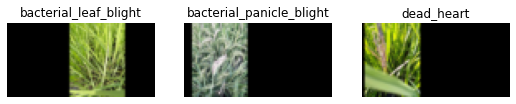

In [ ]:
itfms = Resize((45, 90), method = 'pad', pad_mode = 'zeros')
btfms = None
get_dataloaders(itfms, btfms)

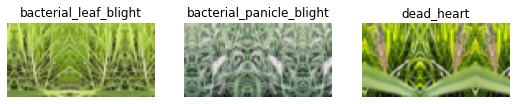

In [ ]:
itfms = Resize((45, 90), method = 'pad', pad_mode = 'reflection')
btfms = None
get_dataloaders(itfms, btfms)

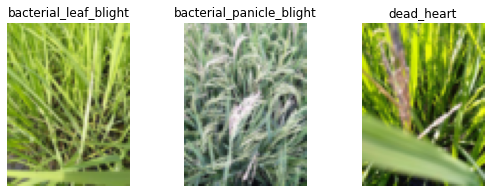

In [ ]:
itfms = Resize((80, 60), method = 'squish')
btfms = None
get_dataloaders(itfms, btfms)

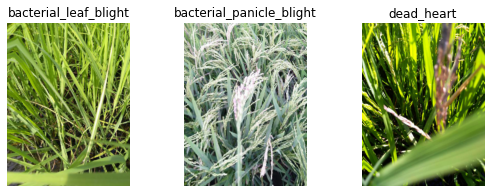

In [ ]:
itfms = Resize((640, 480), method = 'squish')
btfms = aug_transforms(size = (320, 240))
get_dataloaders(itfms, btfms)

In [ ]:
dls.device

device(type='cuda', index=0)

In [ ]:
dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms= Resize(size= (480), method = 'squish'),
                   batch_tfms= aug_transforms(size = (128), min_scale = 1)
                   )

In [ ]:
dls = dblock.dataloaders(data_folder/'train_images', bs = 64)

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics = error_rate, path = model_folder).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


In [ ]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.791930,1.116054,0.367131,01:59


epoch,train_loss,valid_loss,error_rate,time
0,1.117734,0.722851,0.237386,02:13
1,0.784836,0.427308,0.138876,02:05
2,0.540071,0.365717,0.116771,02:04


In [ ]:
sample_submission = pd.read_csv(data_folder/'sample_submission.csv')

In [ ]:
sample_submission

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [ ]:
test_files = get_image_files(data_folder/'test_images')

In [ ]:
test_dl = learn.dls.test_dl(test_files)

In [ ]:
preds, _ = learn.tta(dl = test_dl)

In [ ]:
preds.shape

torch.Size([3469, 10])

In [ ]:
idxs = preds.argmax(dim = 1)

In [ ]:
idxs

TensorBase([7, 8, 7,  ..., 8, 1, 5])

In [ ]:
vocab = np.array(learn.dls.vocab)
vocab

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype='<U24')

In [ ]:
results = pd.Series(vocab[idxs], name = 'idxs')
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [ ]:
sample_submission['label'] = results

In [ ]:
sample_submission

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [ ]:
sample_submission.to_csv(model_folder/'first_sub.csv', index = False)

In [ ]:
model_folder

Path('/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/models/paddi-disease-classification')

In [ ]:
! head /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning/Datasets/models/paddi-disease-classification/first_sub,csv'

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
api.competition_submit('/content/drive/My Drive/Colab Notebooks/Deep Learning/Datasets/models/paddi-disease-classification/first_sub.csv', 'inclass_dl_nov14', 'paddy-disease-classification')

100%|██████████| 70.0k/70.0k [00:02<00:00, 35.1kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification